In [ ]:
import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output
import tensorflow as tf
tf.__version__

'2.15.0'

In [ ]:
#http://efrosgans.eecs.berkeley.edu/cyclegan/datasets/

In [ ]:
import tensorflow_datasets as tfds

In [ ]:
!sed -i 's/# Download FTP/url = url.replace("people.eecs.berkeley.edu\/~taesung_park\/CycleGAN\/datasets", "efrosgans.eecs.berkeley.edu\/cyclegan\/datasets") # Download FTP/' /usr/local/lib/python3.10/dist-packages/tensorflow_datasets/core/download/downloader.py

In [ ]:
tf.random.set_seed(789)

In [ ]:
dataset, metadata = tfds.load('cycle_gan/apple2orange',with_info = True,as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/4 [00:00<?, ? splits/s]

Generating trainA examples...:   0%|          | 0/995 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cycle_gan/apple2orange/3.0.0.incompleteJQC27P/cycle_gan-trainA.tfrecord*..…

Generating trainB examples...:   0%|          | 0/1019 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cycle_gan/apple2orange/3.0.0.incompleteJQC27P/cycle_gan-trainB.tfrecord*..…

Generating testA examples...:   0%|          | 0/266 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cycle_gan/apple2orange/3.0.0.incompleteJQC27P/cycle_gan-testA.tfrecord*...…

Generating testB examples...:   0%|          | 0/248 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cycle_gan/apple2orange/3.0.0.incompleteJQC27P/cycle_gan-testB.tfrecord*...…

Dataset cycle_gan downloaded and prepared to /root/tensorflow_datasets/cycle_gan/apple2orange/3.0.0. Subsequent calls will reuse this data.


In [ ]:
dataset = tfds.load()

In [ ]:
training_A, training_B = dataset['trainA'], dataset['trainB']
testing_A, testing_B = dataset['testA'], dataset['testB']

In [ ]:
quantity_training = len(training_A)
quantity_training

995

In [ ]:
buffer_size = quantity_training
batch_size = 1
img_width = 256
img_height = 256

In [ ]:
def random_crop(img):
  img_crop = tf.image.random_crop(img,size=[img_width,img_height, 3])
  return img_crop

In [ ]:
def normalize(img):
  img = tf.cast(img,tf.float32)
  img = (img/127.5) -1
  return img

In [ ]:
def random_jitter(img):
  img = tf.image.resize(img,[286,286], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  img = random_crop(img)
  img = tf.image.random_flip_left_right(img)
  return img

In [ ]:
def process_training_img(img, label):
  img = random_jitter(img)
  img = normalize(img)
  return img

In [ ]:
def process_testing_img(img, label):
  img = normalize(img)
  return img

In [ ]:
training_A = training_A.cache().map(process_training_img, num_parallel_calls=tf.data.AUTOTUNE).shuffle(buffer_size).batch(batch_size)
training_B = training_B.cache().map(process_training_img,num_parallel_calls=tf.data.AUTOTUNE).shuffle(buffer_size).batch(batch_size)
testing_A = testing_A.cache().map(process_testing_img,num_parallel_calls=tf.data.AUTOTUNE).shuffle(buffer_size).batch(batch_size)
testing_B = testing_B.cache().map(process_testing_img,num_parallel_calls=tf.data.AUTOTUNE).shuffle(buffer_size).batch(batch_size)

In [ ]:
type(training_B)

tensorflow.python.data.ops.batch_op._BatchDataset

In [ ]:
sample_A = next(iter(training_A))
sample_B = next(iter(training_B))

Apple


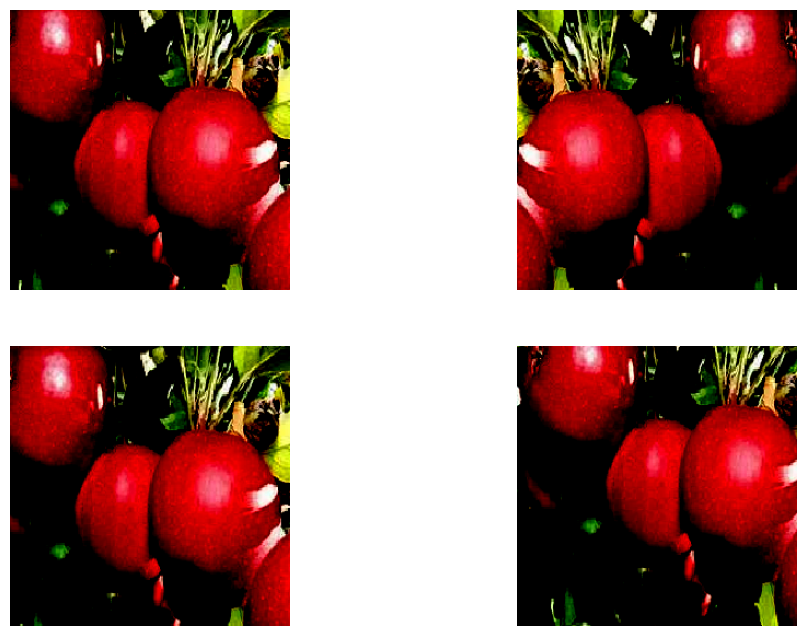

In [ ]:
print('Apple')
plt.figure(figsize=(12,8))
for i in range(4):
  A_jitter = random_jitter(sample_A[0])
  plt.subplot(2,2,i+1)
  plt.imshow(A_jitter)
  plt.axis('off')
plt.show()

In [ ]:
!pip install -q git+https://github.com/tensorflow/examples.git

  Preparing metadata (setup.py) ... done


In [ ]:
from tensorflow_examples.models.pix2pix import pix2pix

In [ ]:
output_channels = 3
generator_g = pix2pix.unet_generator(output_channels,norm_type='instancenorm')
generator_f = pix2pix.unet_generator(output_channels,norm_type='instancenorm')
discriminator_x = pix2pix.discriminator(norm_type='instancenorm', target = False)
discriminator_y = pix2pix.discriminator(norm_type='instancenorm', target = False)

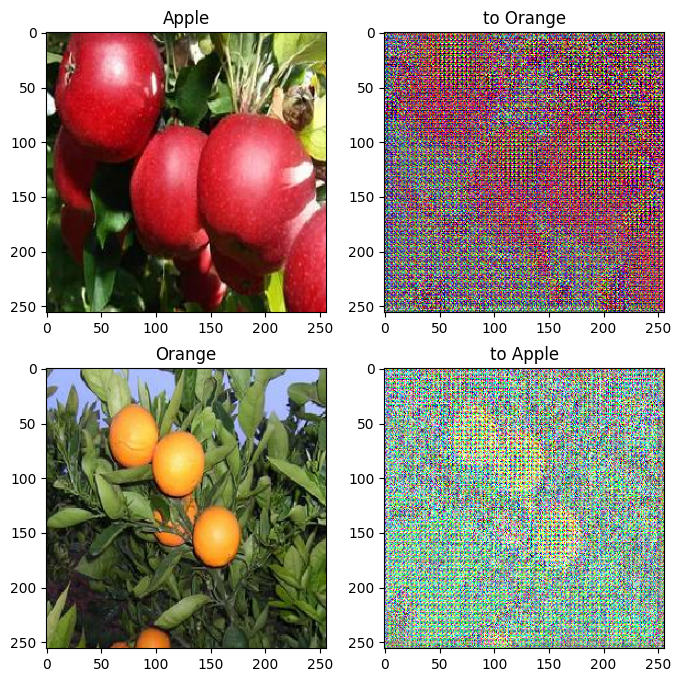

In [ ]:
B_generated = generator_g(sample_A)
A_generated = generator_f(sample_B)
plt.figure(figsize=(8,8))
imgs = [sample_A,B_generated,sample_B,A_generated]
title = ['Apple','to Orange', 'Orange', 'to Apple']
for i in range(len(imgs)):
  plt.subplot(2,2,i+1)
  plt.title(title[i])
  if i%2 == 0:
    plt.imshow(imgs[i][0]*0.5 + 0.5)
  else :
    plt.imshow(imgs[i][0]*0.5 * 6 + 0.5)
plt.show()

In [ ]:
lambda_ = 10
loss = tf.keras.losses.BinaryCrossentropy(from_logits = True)

In [ ]:
def discriminator_loss(real, generated):
  real_loss = loss(tf.ones_like(real),real)
  generated_loss = loss(tf.zeros_like(generated), generated)
  d_total_loss = real_loss + generated_loss
  return d_total_loss

In [ ]:
def generator_loss(generated):
  return loss(tf.ones_like(generated),generated)

In [ ]:
def cycle_loss(real_img,cycled_img):
  loss1 = tf.reduce_mean(tf.abs(real_img - cycled_img))
  return loss1 * lambda_

In [ ]:
def identity_loss(real_img,equal_img):
  loss = tf.reduce_mean(tf.abs(real_img - equal_img))
  return lambda_ * 0.5 *loss

In [ ]:
lr = 0.0002
beta1, beta2 = 0.5, 0.999

In [ ]:
optimizer_generator_g = tf.keras.optimizers.Adam(lr,beta1,beta2)
optimizer_generator_f = tf.keras.optimizers.Adam(lr,beta1,beta2)

optimizer_discriminator_x = tf.keras.optimizers.Adam(lr,beta1,beta2)
optimizer_discriminator_y = tf.keras.optimizers.Adam(lr,beta1,beta2)

In [ ]:
epochs = 10
def generateImage(model,test_input):
  generated = model(test_input)

  plt.figure(figsize=(8,6))

  img_list = [test_input[0],generated[0]]
  title = ['Real Image', 'Generated Image']

  for i in range(2):
    plt.subplot(1,2,i+1)
    plt.title(title[i])
    plt.imshow(img_list[i]*0.5 + 0.5)
    plt.axis('off')
  plt.show()

In [ ]:
@tf.function
def training_step(real_x,real_y):
  with tf.GradientTape(persistent=True) as tape:
    #apple into orange fake
    fake_y = generator_g(real_x,training=True)
    cycle_x = generator_f(fake_y,training = True)

    #Orange into apple fake
    fake_x = generator_f(real_y,training =True)
    cycle_y = generator_g(fake_x,training =True)

    #Identity mapping
    equal_x = generator_f(real_x,training = True)
    equal_y = generator_g(real_y,training = True)

    #Discriminator output
    discriminator_real_x = discriminator_x(real_x,training=True)
    discriminator_fake_x = discriminator_x(fake_x,training=True)
    discriminator_real_y = discriminator_y(real_y,training=True)
    discriminator_fake_y = discriminator_y(fake_y,training=True)

    #loss calculation
    generator_g_loss = generator_loss(discriminator_fake_y)
    generator_f_loss = generator_loss(discriminator_fake_x)
    cycle_loss_total = cycle_loss(real_x,cycle_x) + cycle_loss(real_y,cycle_y)
    total_generator_g_loss = generator_g_loss + cycle_loss_total + identity_loss(real_y,equal_y)
    total_generator_f_loss = generator_f_loss + cycle_loss_total + identity_loss(real_x,equal_x)
    discriminator_x_loss = discriminator_loss(discriminator_real_x,discriminator_fake_x)
    discriminator_y_loss = discriminator_loss(discriminator_real_y,discriminator_fake_y)

    #gradient
    generator_g_gradients = tape.gradient(total_generator_g_loss, generator_g.trainable_variables)
    generator_f_gradients = tape.gradient(total_generator_f_loss, generator_f.trainable_variables)
    discriminator_x_gradient = tape.gradient(discriminator_x_loss, discriminator_x.trainable_variables)
    discriminator_y_gradient = tape.gradient(discriminator_y_loss, discriminator_y.trainable_variables)

    # optimizer
    optimizer_generator_g.apply_gradients(zip(generator_g_gradients,generator_g.trainable_variables))
    optimizer_generator_f.apply_gradients(zip(generator_f_gradients,generator_f.trainable_variables))
    optimizer_discriminator_x.apply_gradients(zip(discriminator_x_gradient,discriminator_x.trainable_variables))
    optimizer_discriminator_y.apply_gradients(zip(discriminator_y_gradient,discriminator_y.trainable_variables))



In [ ]:
def train(training_A,training_B,generator_g,steps):
  for epoch in range(epochs):
    start = time.time()
    n = 0
    for img_x,img_y in tf.data.Dataset.zip((training_A,training_B)):
        training_step(img_x,img_y)
        if n % 10 == 0:
          print('.', end = '')
        n += 1
    clear_output(wait=True)
    generateImage(generator_g,sample_A)
    print('Time taken to train epoch {} : {} second\n'.format(epoch+1,time.time()-start))
    generator_g.save_weights('model_cyclegan.h5')


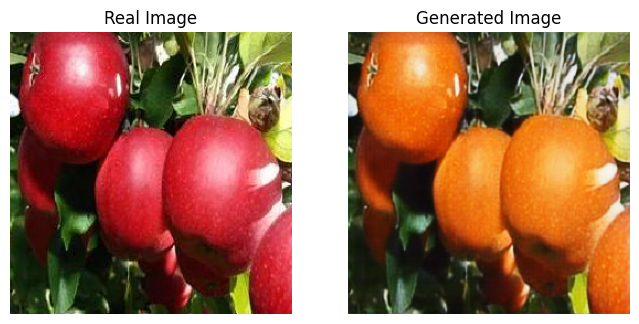

Time taken to train epoch 10 : 423.886780500412 second



In [ ]:
train(training_A,training_B, generator_g,epochs)

In [ ]:
for input in testing_A.take(5):
  generateImage(generator_g,input)